### Sarthak Arora

In [3]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pylab
from scipy.stats import norm
engine = create_engine('sqlite://', echo=False)

### loading the dataset and removing cases with priv_counts 0 or NaN's 
### also filtering out for cases where both mcare_pay_median and priv_pay_median are present

In [4]:
df_main = pd.read_csv("/home/lennon_mccartney/Downloads/priv_mcare_f_pay.csv")
# df_hsp = pd.read_csv("/home/lennon_mccartney/Downloads/Hospital_Master_Sheet.csv")

In [5]:
df_main.head()

,msa,year,site,group,priv_count,priv_pay_mean,priv_pay_median,priv_pay_iqr,mcare_los,mcare_pay_mean,mcare_pay_median,mcare_pay_sd,CBSA_NAME,State,FIPS State Code,lon,lat
0,10180,2018,Inpatient,breast reconstruction,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Abilene, TX",Texas,48,-99.733144,32.448736
1,10420,2018,Inpatient,breast reconstruction,8.0,19937.08375,16147.330,5692.86,2.000000,8313.8475,8298.49,1575.325296,"Akron, OH",Ohio,39,-81.519005,41.081445
2,10500,2018,Inpatient,breast reconstruction,NaN,NaN,NaN,NaN,2.000000,9155.9400,9155.94,NaN,"Albany, GA",Georgia,13,-84.155741,31.578507
3,10540,2018,Inpatient,breast reconstruction,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Albany-Lebanon, OR",Oregon,41,-122.907034,44.536512
4,10580,2018,Inpatient,breast reconstruction,4.0,14837.26000,10420.675,4474.06,2.888889,9230.5000,8003.40,6267.381132,"Albany-Schenectady-Troy, NY",New York,36,-73.653621,42.763648


In [6]:
## removing cases where priv_count is 0 or NaN as they belong to the prediction set
df_train = df_main[(df_main['priv_count'] != 0) & (df_main['priv_count'].notnull()) & (df_main['mcare_pay_median'].notnull()) & (df_main['priv_pay_median'].notnull()) ]

In [7]:
df_train.reset_index(inplace=True)

In [8]:
# df_train.to_sql('train_data', con=engine)

In [9]:
# engine.execute("SELECT msa,[group],count(*) as ct FROM train_data group by 1,2 order by 3 desc").fetchall()

### looking at how the distribution of log(priv_pay_median) looks like

<AxesSubplot:>

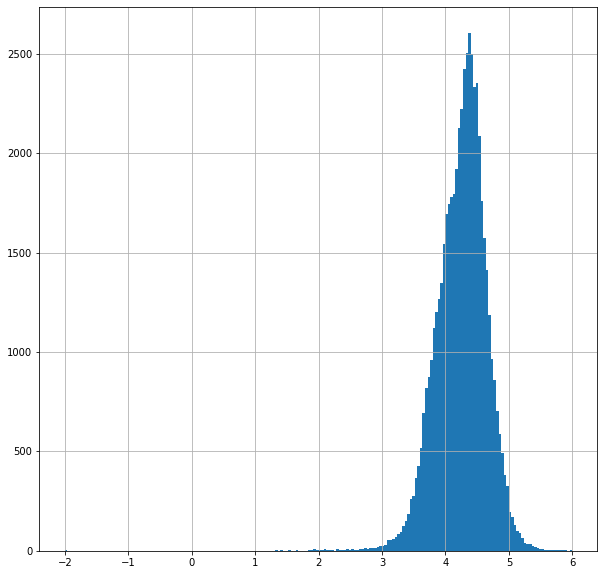

In [10]:
fig = plt.figure(figsize = (10,10))
ax = fig.gca()
np.log10(df_main[df_main["priv_pay_median"] > 0]["priv_pay_median"]).hist(bins = 200, ax = ax)

### looking at the distribution of the difference between the median values for private and medicare

In [11]:
(df_train["priv_pay_median"]-df_train["mcare_pay_median"]).describe()

count     39459.000000
mean      15816.831965
std       25474.567066
min      -91088.045000
25%        4129.882500
50%       10215.610000
75%       19718.665000
max      775469.400000
dtype: float64

<AxesSubplot:>

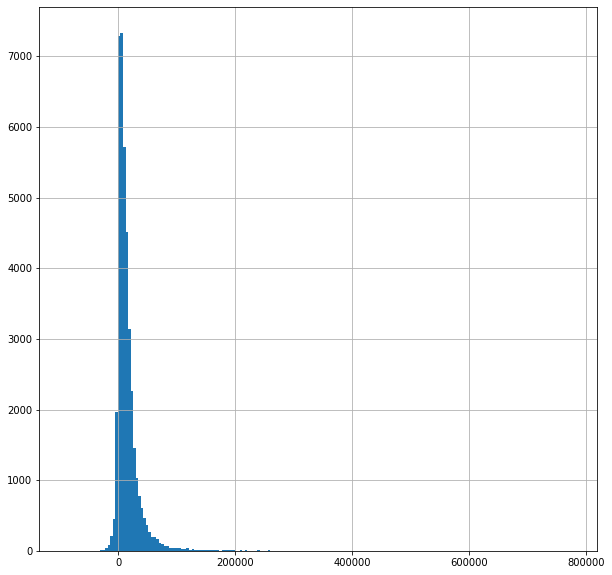

In [12]:
fig = plt.figure(figsize = (10,10))
ax = fig.gca()
(df_train["priv_pay_median"]-df_train["mcare_pay_median"]).hist(bins = 200, ax = ax)
# plt.savefig("hist.png")

### looking at distribution of the above difference at a group level

/home/lennon_mccartney/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/hist.py:370: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


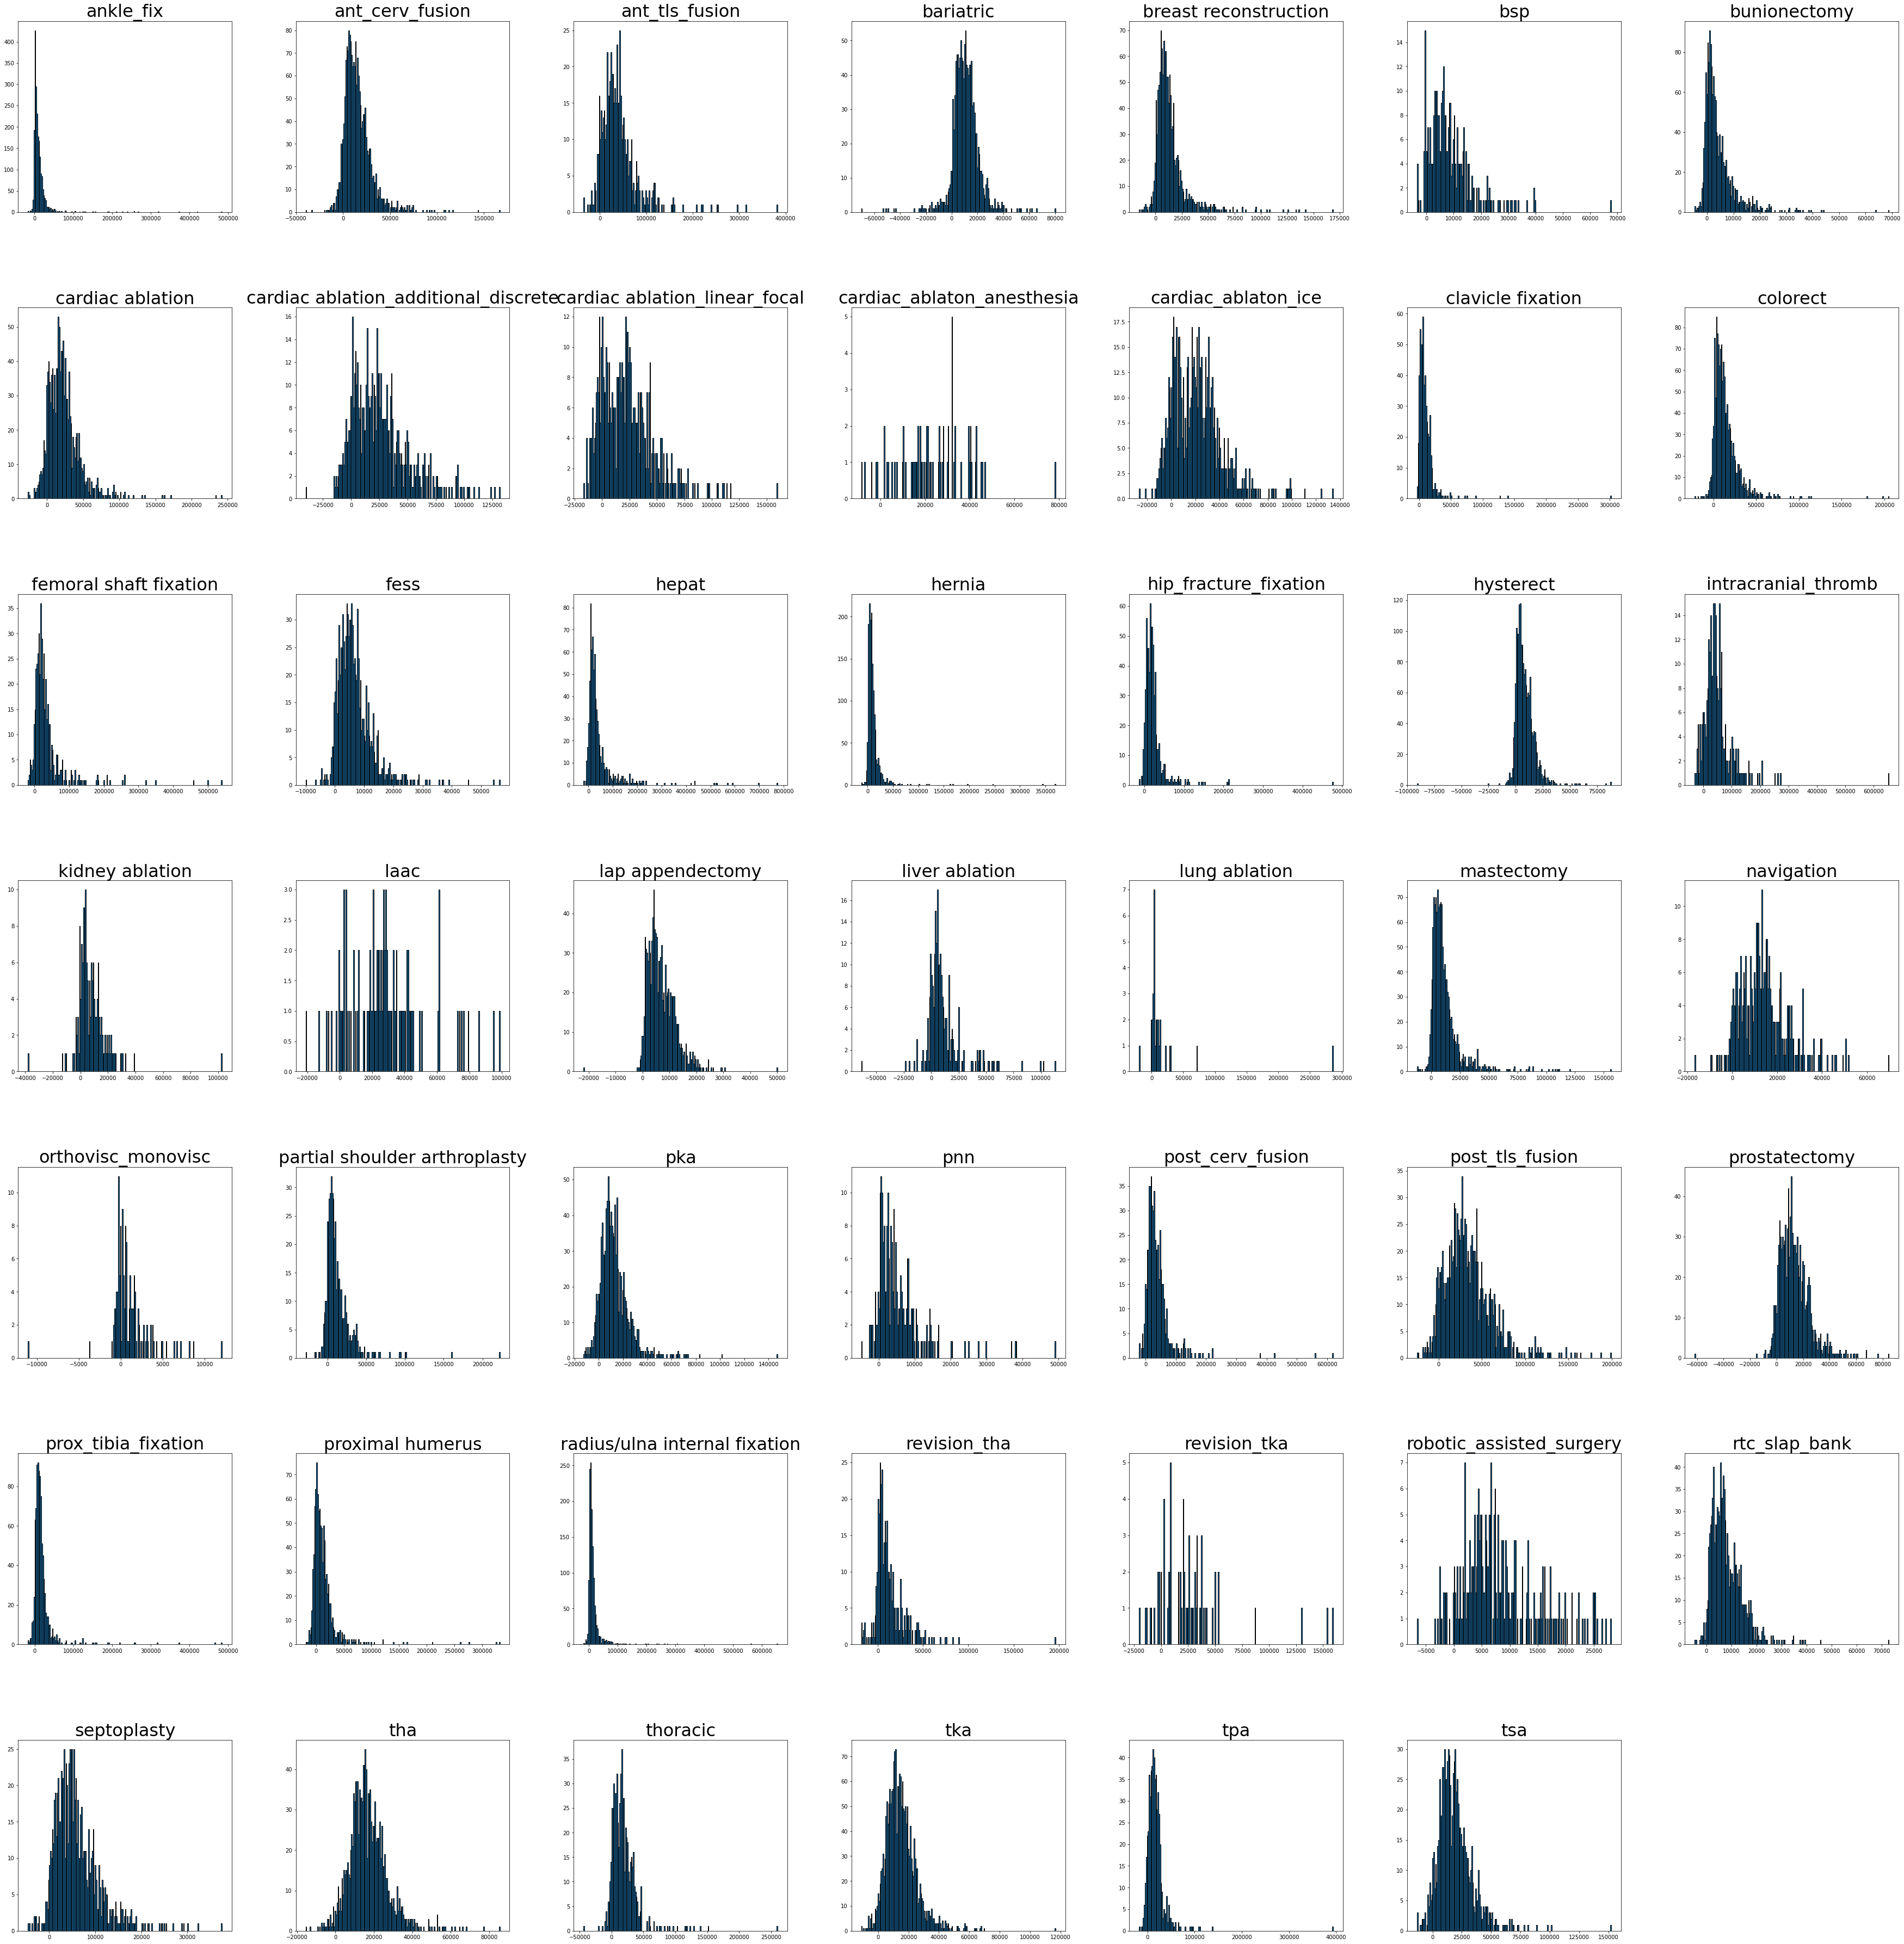

In [14]:
fig = plt.figure(figsize = (60,65))
ax = fig.gca()
plt.tight_layout()
fig = (df_train["priv_pay_median"]-df_train["mcare_pay_median"]).hist(by = df_train["group"] ,bins = 200, ax = ax,ec="k",rot = 0)
[x.title.set_size(32) for x in fig.ravel()]
plt.savefig("diff_gp_hist.png",dpi = 100)

### checking if tka group histogram above can pass as a normal distribution

In [15]:
dt_pts = df_train[df_train["group"] == "tka"]["priv_pay_median"] - df_train[df_train["group"] == "tka"]["mcare_pay_median"]
gp_stats = dt_pts.describe()
mu = gp_stats[1]
std = gp_stats[2]

<AxesSubplot:ylabel='Count'>

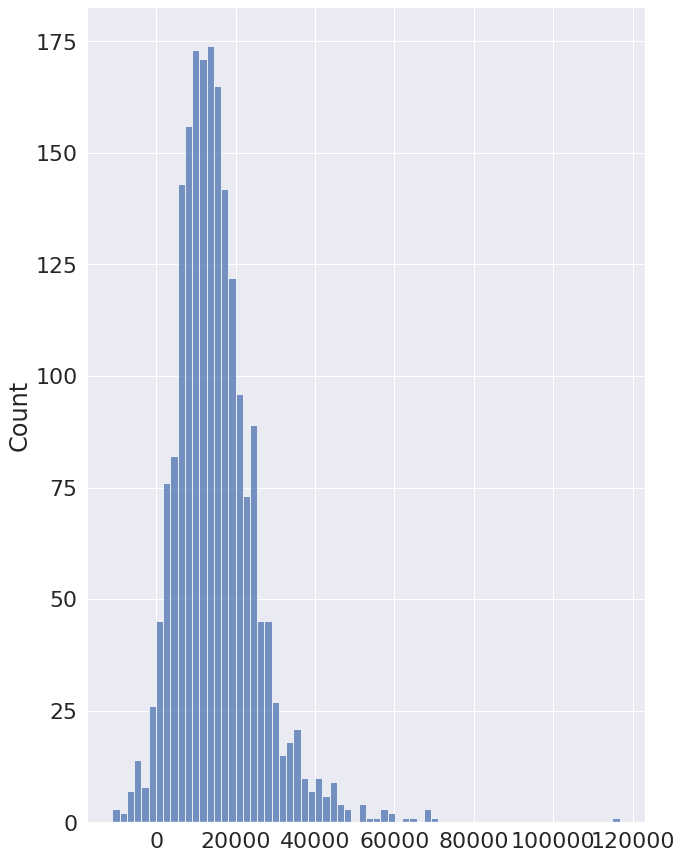

In [16]:
plt.figure(figsize=(10,15))
sns.set(font_scale=2)
sns.histplot(dt_pts)

/home/lennon_mccartney/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


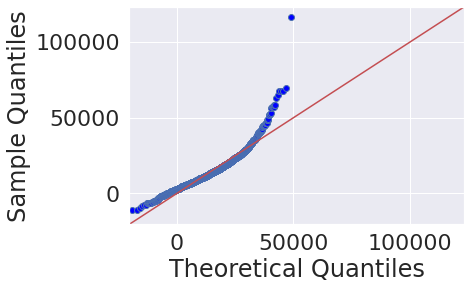

In [17]:
sm.qqplot(dt_pts,dist=norm(mu,std), line ='45')
pylab.show()

### the QQ plot above shows a huge deviation from normal behaviour, hence we try to remove outliers and make a QQ plot again, we also look at what kind of rows are we removing as outliers 

In [19]:
rmv_outliers = dt_pts[(dt_pts > mu - 3*std) & (dt_pts < mu + 3*std)].values
outliers = list(dt_pts[(dt_pts <= mu - 3*std) | (dt_pts >= mu + 3*std)].index)
dt_out = df_train.loc[df_train.apply(lambda x: x['index'] in outliers, axis=1)]
dt_out

,index,msa,year,site,group,priv_count,priv_pay_mean,priv_pay_median,priv_pay_iqr,mcare_los,mcare_pay_mean,mcare_pay_median,mcare_pay_sd,CBSA_NAME,State,FIPS State Code,lon,lat
5609,14628,47894,2020,Outpatient,post_cerv_fusion,1.0,12235.62000,12235.620,0.0000,0.000000,6985.335000,71.85,13875.035360,"Washington-Arlington-Alexandria, DC-VA-MD-WV",Virginia,51,-77.368316,39.134974
5814,14938,38340,2018,Inpatient,post_tls_fusion,2.0,19587.46000,19587.460,681.6100,10.000000,32043.380000,32043.38,NaN,"Pittsfield, MA",Massachusetts,25,-73.245382,42.450085
5819,14945,39340,2018,Inpatient,post_tls_fusion,16.0,50772.16250,45869.805,30407.6800,3.082677,27785.656060,24986.60,8950.401953,"Provo-Orem, UT",Utah,49,-111.694648,40.296898
5879,15016,45820,2018,Inpatient,post_tls_fusion,3.0,105737.26000,90744.500,56941.3100,3.457627,26749.052710,22177.32,11400.822400,"Topeka, KS",Kansas,20,-95.675158,39.047345
5881,15018,46060,2018,Inpatient,post_tls_fusion,18.0,53965.38778,55533.395,30599.4875,3.413551,30583.553060,29827.73,11552.783620,"Tucson, AZ",Arizona,4,-110.974711,32.222607
5951,15113,15764,2019,Inpatient,post_tls_fusion,47.0,60486.61723,52193.060,28620.9650,3.594444,37652.319940,34805.26,12922.453230,"Boston-Cambridge-Newton, MA-NH",Massachusetts,25,-71.058830,42.360071
5959,15121,16300,2019,Inpatient,post_tls_fusion,9.0,52371.88333,57260.130,28023.5300,3.727273,26221.624550,24042.03,5321.346872,"Cedar Rapids, IA",Iowa,19,-91.665623,41.977880
6058,15265,29820,2019,Inpatient,post_tls_fusion,63.0,70990.90889,63192.900,28453.1400,3.432967,32706.230440,32790.17,17845.910310,"Las Vegas-Henderson-Paradise, NV",Nevada,32,-115.146665,36.097195
6059,15267,30020,2019,Inpatient,post_tls_fusion,3.0,73439.13667,64040.000,30049.3950,3.217391,26939.818700,23182.96,5893.185582,"Lawton, OK",Oklahoma,40,-98.395929,34.603567
6081,15301,33700,2019,Inpatient,post_tls_fusion,2.0,98507.12000,98507.120,69509.7000,5.523810,51870.478570,40709.44,25302.974220,"Modesto, CA",California,6,-120.997001,37.639260


<AxesSubplot:ylabel='Count'>

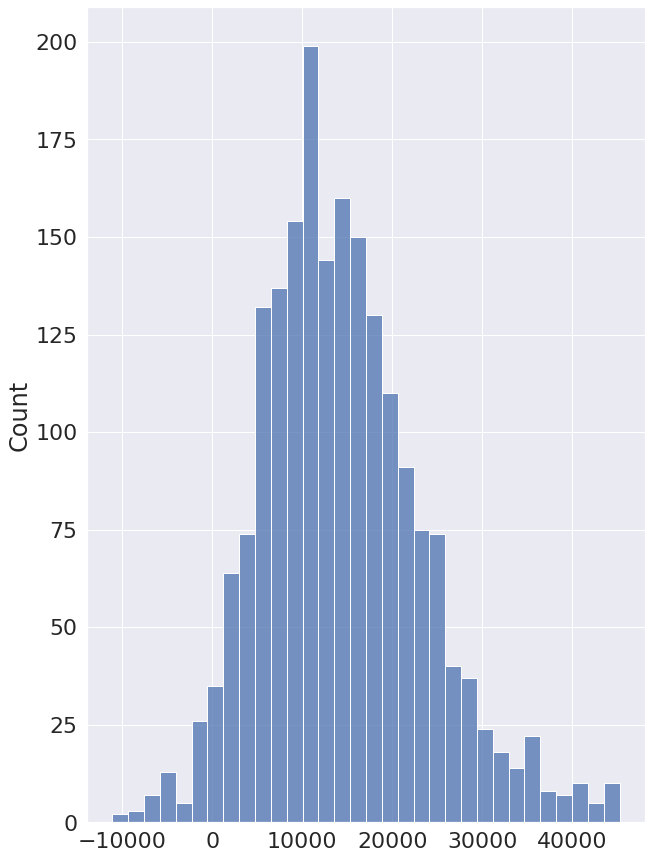

In [20]:
plt.figure(figsize=(10,15))
sns.set(font_scale=2)
sns.histplot(rmv_outliers)

/home/lennon_mccartney/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


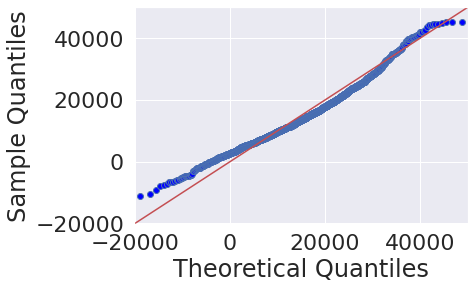

In [21]:
sm.qqplot(rmv_outliers,dist=norm(mu,std), line ='45')
pylab.show()

In [26]:
print("MLE_Diff:",np.mean(rmv_outliers),"MLE_std:",np.std(rmv_outliers))

MLE_Diff: 12917.50370952381 MLE_std: 9880.142231448523


### Repeating the above steps to create QQ plots for all the groups after removing outliers from every group

/home/lennon_mccartney/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/home/lennon_mccartney/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/home/lennon_mccartney/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/home/lennon_mccartney/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker

/home/lennon_mccartney/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/home/lennon_mccartney/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/home/lennon_mccartney/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/home/lennon_mccartney/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker

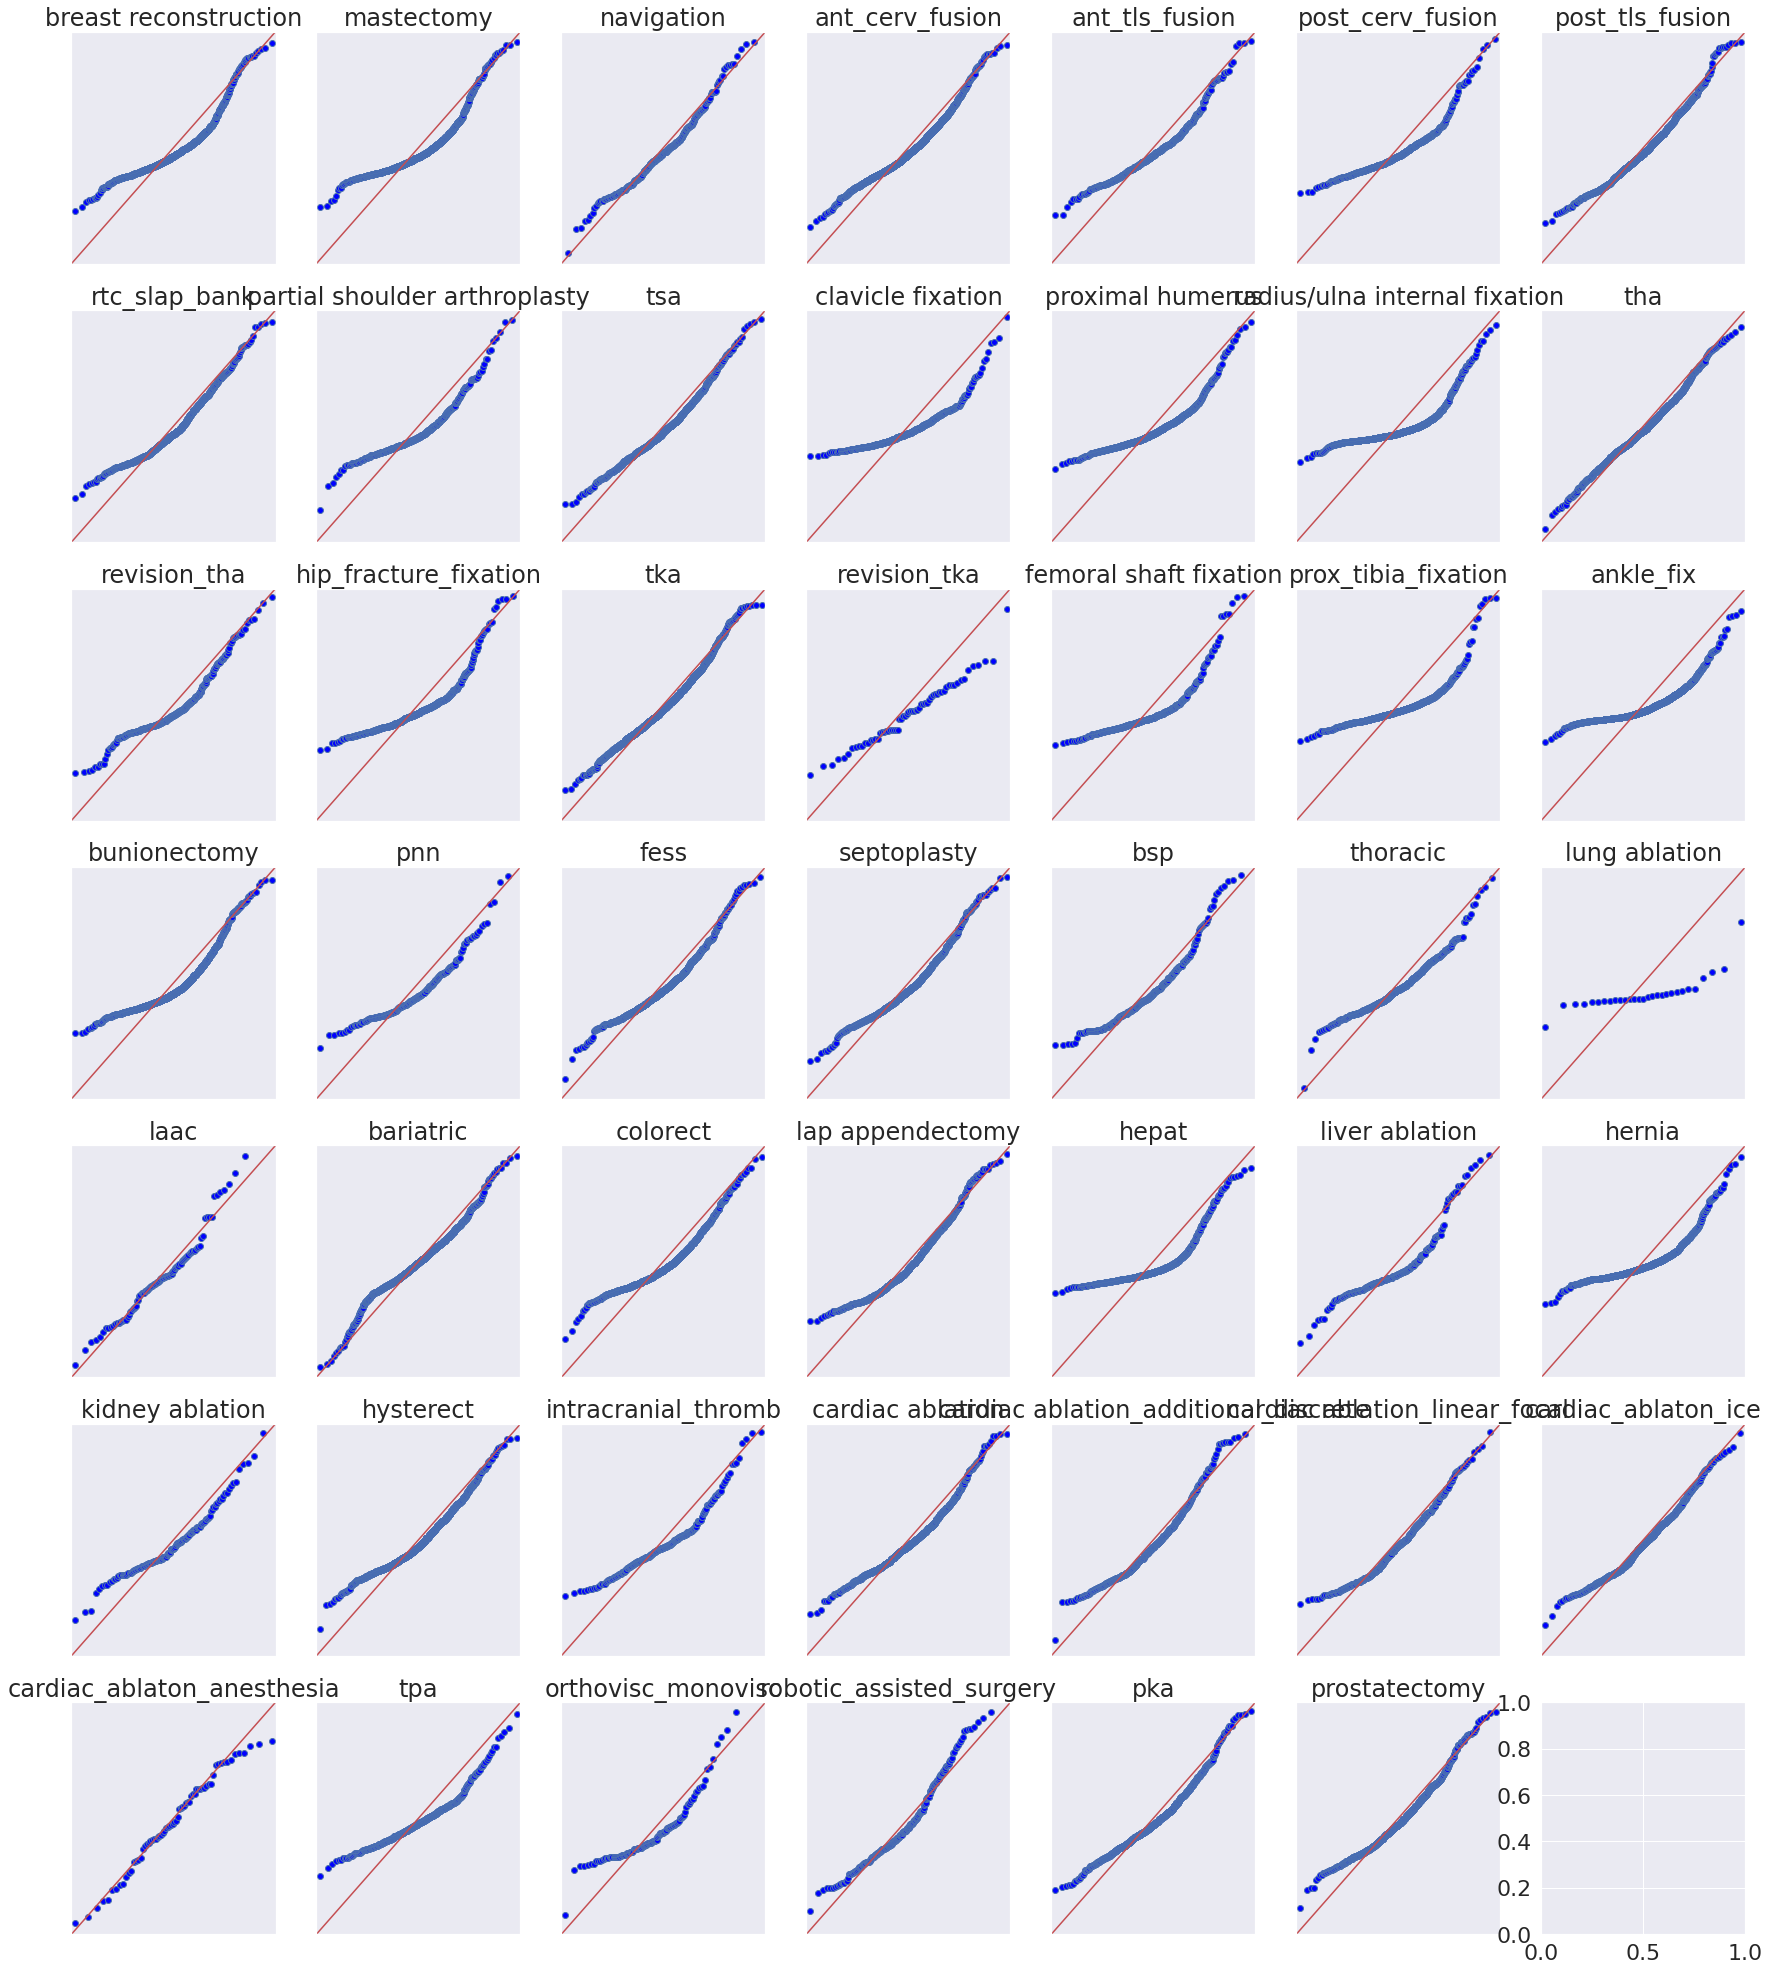

In [22]:
fig, axs = plt.subplots(7, 7, figsize=(30,35))
gp_list = df_train["group"].unique()
outlier_data = []
figs = []
for i,x in enumerate(gp_list):
    dt_pts = df_train[df_train["group"] == x]["priv_pay_median"] - df_train[df_train["group"] == x]["mcare_pay_median"]
    gp_stats = dt_pts.describe()
    mu = gp_stats[1]
    std = gp_stats[2]
    rmv_outliers = dt_pts[(dt_pts > mu - 3*std) & (dt_pts < mu + 3*std)].values
    outliers = list(dt_pts[(dt_pts <= mu - 3*std) | (dt_pts >= mu + 3*std)].index)
    dt_out = df_train.loc[df_train.apply(lambda x: x['index'] in outliers, axis=1)]
#     ax.set(xlabel=None)
#     ax.set(ylabel=None)

#     plt.gca().set_title(x) 

    sm.qqplot(rmv_outliers,dist=norm(mu,std), line ='45',ax=axs[int(i/7),i%7])
    axs[int(i/7),i%7].get_yaxis().set_visible(False)
    axs[int(i/7),i%7].get_xaxis().set_visible(False)
    axs[int(i/7),i%7].set_title(x)
    outlier_data.append(dt_out)
    
plt.savefig("qqplots.png")